# Sparse_NN_Methods 
(Last updated March 8th, 2017) - Qi Pan

## Table of Contents
**1. Sparse Data Representations**
* 1.1 Data Overview
* 1.2 X_correct and X_views
* 1.3 X_correct_latest and X_views latest
* 1.4 X_correct_cnt_latest and X_incorrect_cnt_latest

**2. Baseline methods**
* 2.1 Global Average
* 2.2 Within Col (Step) Average 
* 2.3 Within Row (Student) Average

**3. Sparse NN Methods**
* 3.1 Cosine Similarity NN with {0, 1} encoding
* 3.2 Cosine Similarity NN with {0, 1} encoding + no self similarity
* 3.3 Cosine Similarity NN with {-1, 0, 1} encoding
* 3.4 L1 Similarity NN with {0, 1} encoding
* 3.5 L1 Similarity NN with {-1, 0, 1} encoding
* 3.6 Custom Similarity

**4. Test Results**
* 4.1 Initial Testing
    * 4.1.1 Accuracy
    * 4.1.2 Positive and Negative Predictive Value
    * 4.1.3 True Positive and Negative Rates
* 4.2 Custom Similarity Testing and Tuning
    * 4.2.1 Accuracy

## 1.) Sparse Data Representations
### 1.1) Data Overview

The dataset is from an Intelligent Tutorial System called Bridge to Algebra and captures student responses from the 2008-2009 school year. In the analysis below we focus on a subsegment of the whole dataset that contains:

In [1]:
import pandas as pd

#load the dataset
single_KC_data = pd.read_pickle('/Users/qipanda/Documents/2016-2017_KDD_Thesis/education_data'+\
    '/bridge_to_algebra_2008_2009/bridge_0809_KC.pkl')

#Number of students, problems, steps, problem-step combinations
print('number of unique students = {}'.format(single_KC_data['Anon Student Id'].nunique()))
print('number of unique problems = {}'.format(single_KC_data['Problem Name'].nunique()))
print('number of unique steps = {}'.format(single_KC_data['Step Name'].nunique()))
print('number of unique problem-step combinations = {}'.\
    format(single_KC_data.groupby(['Problem Name', 'Step Name']).size().shape[0]))

number of unique students = 4593
number of unique problems = 909
number of unique steps = 113
number of unique problem-step combinations = 30043


### 1.2) X_correct and X_views

The dataset is represented mathematicaly by 3D matrices defined as such:

\begin{equation}
    \mathbf{X}_{correct} \in \mathbb{R}^{MxNxT}\text{, } 
    \mathbf{X}_{views} \in \mathbb{R}^{MxNxT}
\end{equation}

\begin{equation}
    M =\text{number of unique students}\text{, }
    N =\text{number of unique problem-step combinations}\text{, }
    T =\text{number of discrete time interval}
\end{equation}

\begin{equation}
    X_{correct}^{(i,\ j,\ t)}=     
    \begin{cases}
        0, & \text{if student $i$ $[$is wrong about OR did not do$]$ problem-step $j$ at time $t$}\\
        1, & \text{if student $i$ got problem-step $j$ correct at time $t$}
    \end{cases}
\end{equation}

\begin{equation}
    X_{views}^{(i,\ j,\ t)}=
    \begin{cases}
        \text{times student $i$ has seen problem-step $j$ at time $t$}, & \text{if this problem-step was attempted at time $t$}\\
        0, & \text{else}
    \end{cases}
\end{equation}

\begin{equation}
    \forall i = 1,\dots,M\text{ }
    \forall j = 1,\dots,N\text{ }
    \forall t = 1,\dots,T
\end{equation}

In python, these 3D matrices are represented by lists of 2D sparse matrices where list indices represent $t$:

In [2]:
import DataManipulators
import loading_util as lu
import numpy as np

#load the data
dm = lu.load_pickle('test_preprocessed_DM', 'saved_ftrs')

#list indices reprent t, each member is a 2D sparse coo matrix
print(type(dm.sparse_ftrs['X_correct'][0]))
print(type(dm.sparse_ftrs['X_views'][0]))

Loading pickle from saved_ftrs/test_preprocessed_DM.pickle
<class 'scipy.sparse.coo.coo_matrix'>
<class 'scipy.sparse.coo.coo_matrix'>


### 1.3) X_correct_latest and X_views_latest

Because students can try problem-step combinations more than once, their latest "correctness" on a given problem-step may change. $X_{correct\_latest}$ stores the most recent "correctness" at time $t$ for all problem-steps they've attemptd up to time $t$. Similairly, whereas $X_{views}$ only contained the views for a given problem-step exectued at time $t$, we are also interested in the total views a student had on all problem-steps they've attempted up to time $t$. The mathematical definitions are as follows:

\begin{equation}
    \mathbf{X}_{correct\_latest} \in \mathbb{R}^{MxNxT}\text{, }
    \mathbf{X}_{views\_latest} \in \mathbb{R}^{MxNxT}
\end{equation}

\begin{equation}
    M =\text{number of unique students}\text{, }
    N =\text{number of unique problem-step combinations}\text{, }
    T =\text{number of discrete time interval}
\end{equation}

\begin{equation}
    X_{correct\_latest}^{(i,\ j,\ t)}=     
    \begin{cases}
        0, & \text{if student $i$ $[$was wrong on their last attempt of OR did not do$]$ problem-step $j$ up to time $t$}\\
        1, & \text{if student $i$ got problem-step $j$ correct on their last attempt up to time $t$}
    \end{cases}
\end{equation}

\begin{equation}
    X_{views\_latest}^{(i,\ j,\ t)}=\text{number of times student $i$ has attempted problem-step $j$ up to time $t$}
\end{equation}

\begin{equation}
    \forall i = 1,\dots,M\text{ }
    \forall j = 1,\dots,N\text{ }
    \forall t = 1,\dots,T
\end{equation}

In python, these 3D matrices are represented by lists of 2D sparse matrices where list indices represent $t$:

### 1.4) X_correct_cnt_latest and X_incorrect_cnt_latest

For a given student $i$, what is their running count of corrects/incorrects for a given problem-step $j$ at time $t$. Corrects are converted into binary while incorrects are left as counts. The mathematical definitions are as follows:

\begin{equation}
    \mathbf{X}_{correct\_cnt\_latest} \in \mathbb{R}^{MxNxT}\text{, }
    \mathbf{X}_{incorrect\_cnt\_latest} \in \mathbb{R}^{MxNxT}
\end{equation}

\begin{equation}
    M =\text{number of unique students}\text{, }
    N =\text{number of unique problem-step combinations}\text{, }
    T =\text{number of discrete time interval}
\end{equation}

\begin{equation}
    X_{correct\_cnt\_latest}^{(i,\ j,\ t)}=     
    \begin{cases}
        0, & \text{if student $i$ has never been correct on problem-step $j$ at time $t$}\\
        1, & \text{if student $i$ has been correct at one point on problem-step $j$ at time $t$}
    \end{cases}
\end{equation}

\begin{equation}
    X_{incorrect\_cnt\_latest}^{(i,\ j,\ t)}=\text{number of times student $i$ has been incorrect on problem-step $j$ at time $t$}
\end{equation}

\begin{equation}
    \forall i = 1,\dots,M\text{ }
    \forall j = 1,\dots,N\text{ }
    \forall t = 1,\dots,T
\end{equation}

In python, these 3D matrices are represented by lists of 2D sparse matrices where list indices represent $t$:

## 2.) Baseline Methods
### 2.1) Global Average
The most naive method, just predict all $0$ or $1$ based on whether the average of all non-sparse elements in $X_{correct\_latest}$ is $\geq0.5$, more formally:

\begin{equation}
    \mathcal{A} = \text{set of $(i,\ j,\ t)$ indices where student $i$ has attempted problem-step $j$ at or before time $t$}
\end{equation}

\begin{equation}
    X_{pred}^{(i,\ j,\ t)} = 
    \begin{cases}
        1, & \text{if } \frac{\sum_{i',\ j' \in \mathcal{A}^{(t)}} X_{correct\_latest}^{(i',\ j',\ t)}}
        {\lvert\mathcal{A}^{(t)}\rvert}
        \geq
        0.5\\
        0, & \text{else}
    \end{cases}
\end{equation}

### 2.2) Within Col (Problem-Step) Average)
A slightly more sophisticated way of doing the average is to predict the average across all students on a given problem-step. This happens to correspond to taking the average of a column in our 2D sparse matrices for a given time $t$. formally:

\begin{equation}
    X_{pred}^{(i,\ j,\ t)} = 
    \begin{cases}
        1, & \text{if } \frac{\sum_{i'\in \mathcal{A}^{(j,\ t)}} X_{correct\_latest}^{(i',\ j,\ t)}}
        {\lvert\mathcal{A}^{(j,\ t)}\rvert}
        \geq
        0.5 \\
        0, & \text{else}
    \end{cases}
\end{equation}

### 2.3) Within Row (Student) Average)
Similair to the Within Col execpt now for rows, predict using the hitorical average of the student. This happens to correspond to taking the average of a row in our 2D sparse matrices for a given time $t$. formally:

\begin{equation}
    X_{pred}^{(i,\ j,\ t)} = 
    \begin{cases}
        1, & \text{if } \frac{\sum_{j'\in \mathcal{A}^{(i,\ t)}} X_{correct\_latest}^{(i,\ j',\ t)}}
        {\lvert\mathcal{A}^{(i,\ t)}\rvert}
        \geq
        0.5 \\
        0, & \text{else}
    \end{cases}
\end{equation}

## 3.) Sparse NN Methods
### 3.1) Cosine Similarity NN with {0, 1} encoding
First we calculate cosine similarity $\mathbf{S}$ between students (rows) based on the default ${0, 1}$ encoding defined by $\mathbf{X}_{correct\_latest}$ earlier where:

\begin{equation}
    \mathbf{S} \in \mathbb{R}^{MxMxT}
\end{equation}

\begin{equation}
    S^{(i_1,\ i_2,\ t)} = \frac{
            X_{correct\_latest}^{(i_1,\ \cdot,\ t)} \cdot X_{correct\_latest}^{(i_2,\ \cdot,\ t)}
        }
        {
            \lVert X_{correct\_latest}^{(i_1,\ \cdot,\ t)}\rVert \ \lVert X_{correct\_latest}^{(i_2,\ \cdot,\ t)}\rVert
        }
\end{equation}

Next we obtain a base prediction matrix which contains the sum product of the $i^{th}$ students similarity row from $\mathbf{S}$ and the coresponding $j^{th}$ problem-step column in $\mathbf{X}_{correct\_latest}$ This is then element wise divided by the sum of similarity scores for a given student $i$ and problem-step $j$, but only if those have students attempted the problem-step before or on current time $t$. The resulting prediction matrix is formalized as such: 

\begin{equation}
    \mathbf{X}_{base\_pred}^{(t)} = \mathbf{S}^{(t)} \cdot \mathbf{X}_{correct\_latest}^{(t)}
\end{equation}

\begin{equation}
    X_{attempt\_latest}^{(i,\ j,\ t)} =
    \begin{cases}
        1, & \text{if student $i$ has attempted problem-step $j$ before or at time $t$}\\
        0, & \text{else}
    \end{cases}
\end{equation}

\begin{equation}
    \forall i = 1,\dots,M\text{ }
    \forall j = 1,\dots,N\text{ }
    \forall t = 1,\dots,T
\end{equation}

\begin{equation}
    \mathbf{X}_{weight\_divisor}^{(t)} = \mathbf{S}^{(t)} \cdot \mathbf{X}_{attempt\_latest}^{(t)} 
\end{equation}

\begin{equation}
    \mathbf{X}_{pred}^{(t+1)} = \mathbf{X}_{base\_pred}^{(t)} \circ \frac{1}{\mathbf{X}_{weight\_divisor}^{(t)}}
\end{equation}

### 3.2) Cosine Similarity NN with {0, 1} encoding + no self similarity

This method is just like 3.1) except the similarity matrix $\mathbf{S}$ will have $0$ down the diagonal in order to prevent the students past performance on a problem-step contribute to their prediction. The reasoning for this is that because a student will always be completely similair to themselves, their history may overpower the contribution of other students to their predicted "correctness" defeating the purpose of NN methods. The final prediction matrix at for time $t+1$ is:

\begin{equation}
    \mathbf{S}_{noself}^{(i_1,\ i_2,\ t)} = 
    \begin{cases}
        0, & \text{if $i_1 = i_2$}\\
        \mathbf{S}^{(i_1,\ i_2,\ t)}, & \text{else}
    \end{cases}
\end{equation}

\begin{equation}
    \mathbf{X}_{weight\_divisor\_noself}^{(t)} = \mathbf{S}_{noself}^{(t)} \cdot \mathbf{X}_{attempt\_latest}^{(t)} 
\end{equation}

\begin{equation}
    \mathbf{X}_{pred}^{(t+1)} = \mathbf{X}_{base\_pred}^{(t)} \circ \frac{1}{\mathbf{X}_{weight\_divisor\_noself}^{(t)}}
\end{equation}

### 3.3) Cosine Similarity NN with {-1, 0, 1} encoding
Instead of encoding absent and incorrect problem-steps as the same value, they are now distinguished by encoding incorrects as -1, penalizing the weighted average accordingly and providing more "resistance" to correct responses by similair students in the final prediction calculation. The formulation is thus the same as 3.1) but now all incorrects in $\mathbf{X}_{correct\_latest}$ turn from $0$ to  $-1$, more fomally:

\begin{equation}
    X_{correct\_latest}^{(i,\ j,\ t)}=     
    \begin{cases}
        -1 & \text{if student $i$ was wrong on their last attempt of problem-step $j$ up to time $t$}\\
        0 & \text{if student $i$ did not do problem-step $j$ up to time $t$}\\
        1 & \text{if student $i$ got problem-step $j$ correct on their last attempt up to time $t$}
    \end{cases}
\end{equation}

\begin{equation}
    \forall i = 1,\dots,M\text{ }
    \forall j = 1,\dots,N\text{ }
    \forall t = 1,\dots,T
\end{equation}

After this modification of $\mathbf{X}_{correct\_latest}$, the formulation is identical to 3.1)

### 3.4) L1 Similarity NN with {0, 1} encoding
Our $\mathbf{S}$ matrix will now be measured using $L1$ similairty instead. The definition is as follows:

\begin{equation}
    \mathbf{S} \in \mathbb{R}^{MxMxT}
\end{equation}

\begin{equation}
    S^{(i_1,\ i_2,\ t)} = (\max{(X_{correct\_latest}^{(t)})} - \min{(X_{correct\_latest}^{(t)})}) 
    - \frac{
            \lVert X_{correct\_latest}^{(i_1,\ \cdot,\ t)} - X_{correct\_latest}^{(i_2,\ \cdot,\ t)}\rVert_1
        }
        {
            N
        }
\end{equation}

\begin{equation}
    S^{(i_1,\ i_2,\ t)} = (1 - 0) 
    - \frac{
            \lVert X_{correct\_latest}^{(i_1,\ \cdot,\ t)} - X_{correct\_latest}^{(i_2,\ \cdot,\ t)}\rVert_1
        }
        {
            N
        }
\end{equation}

\begin{equation}
    S^{(i_1,\ i_2,\ t)} = 1
    - \frac{
            \lVert X_{correct\_latest}^{(i_1,\ \cdot,\ t)} - X_{correct\_latest}^{(i_2,\ \cdot,\ t)}\rVert_1
        }
        {
            N
        }
\end{equation}

### 3.5) L1 Similarity NN with {-1, 0, 1} encoding
Same as 3.4 but now X_{correct\_latest} is defined to include incorrects as -1 (as in 3.3). Formally:

\begin{equation}
    X_{correct\_latest}^{(i,\ j,\ t)}=     
    \begin{cases}
        -1 & \text{if student $i$ was wrong on their last attempt of problem-step $j$ up to time $t$}\\
        0 & \text{if student $i$ did not do problem-step $j$ up to time $t$}\\
        1 & \text{if student $i$ got problem-step $j$ correct on their last attempt up to time $t$}
    \end{cases}
\end{equation}

\begin{equation}
    \forall i = 1,\dots,M\text{ }
    \forall j = 1,\dots,N\text{ }
    \forall t = 1,\dots,T
\end{equation}

\begin{equation}
    S^{(i_1,\ i_2,\ t)} = (\max{(X_{correct\_latest}^{(t)})} - \min{(X_{correct\_latest}^{(t)})}) 
    - \frac{
            \lVert X_{correct\_latest}^{(i_1,\ \cdot,\ t)} - X_{correct\_latest}^{(i_2,\ \cdot,\ t)}\rVert_1
        }
        {
            N
        }
\end{equation}

\begin{equation}
    S^{(i_1,\ i_2,\ t)} = (1 - (-1)) 
    - \frac{
            \lVert X_{correct\_latest}^{(i_1,\ \cdot,\ t)} - X_{correct\_latest}^{(i_2,\ \cdot,\ t)}\rVert_1
        }
        {
            N
        }
\end{equation}

\begin{equation}
    S^{(i_1,\ i_2,\ t)} = 2
    - \frac{
            \lVert X_{correct\_latest}^{(i_1,\ \cdot,\ t)} - X_{correct\_latest}^{(i_2,\ \cdot,\ t)}\rVert_1
        }
        {
            N
        }
\end{equation}

### 3.6) Custom Similarity
Leveraging the positive results from 4.1 using method 3.3, it appears that utilizing incorrects as a "negative" can inform NN-methods to perform better in terms of overall accuracy. This method defines a distance, $D$, between users based on the current running count of corrects and incorrects defined in 1.4. Formally, a vector of size $N$ is created between each student pair, and then aggregated (the aggregation function can change) to create a distance:

\begin{equation}
    d^{(i_1,\ i_2,\ t,\ j)} = w_{cor} \cdot \lvert X_{correct\_cnt\_latest}^{(i_1,\ j,\ t)} - X_{correct\_cnt\_latest}^{(i_2,\ j,\ t)}\rvert + w_{incor} \cdot \lvert X_{incorrect\_cnt\_latest}^{(i_1,\ j,\ t)} - X_{incorrect\_cnt\_latest}^{(i_2,\ j,\ t)}\rvert
\end{equation}

\begin{equation}
    D^{(i_1,\ i_2,\ t)} = agg\_func(\mathbf{d}^{(i_1,\ i_2,\ t,\ \cdot)})
\end{equation}

\begin{equation}
    S^{(i_1,\ i_2,\ t)} = 1
    - \frac{
            D^{(i_1,\ i_2,\ t)}
        }
        {
            \max(\mathbf{D})
        }
\end{equation}

Since any element of $\mathbf{D}$ is positive, $\max(\mathbf{D})$ is the same as the range of $\mathbf{D}$ and thus the similairity calculation is normalized with it.


## 4.) Test Results

### 4.1) Initial Testing
The 3 baseline and 5 NN methods were tested over the same data for 50 discrete time periods. The training set was always from $t=0$ to $t_{cur}$ (whatever iteration we were on) and the predicted set would be $t_{cur}+1$. The results outputted True/False Positives/Negatives which could then be used to calculate Accuracy, +/- Predictive Value, and True Positive/Negative Rates.

In [3]:
#so that plots show inline for this notebook in the results
%matplotlib notebook 

import graphing_util as gu
#load previously run results
results_cos = lu.load_pickle('test_results_3methods_50tm', 'results')
results_l1 = lu.load_pickle('test_results_twol1methods_50tm', 'results')
results = [*results_cos, *results_l1]

Loading pickle from results/test_results_3methods_50tm.pickle
Loading pickle from results/test_results_twol1methods_50tm.pickle


#### 4.1.1) Accuracy

Essentially no difference when except for that a threshold of 0.5 was better than 0.7 or 0.3 (0.7 performing bad is expected given the high amount of "corrects" in the dataset)

<IPython.core.display.Javascript object>


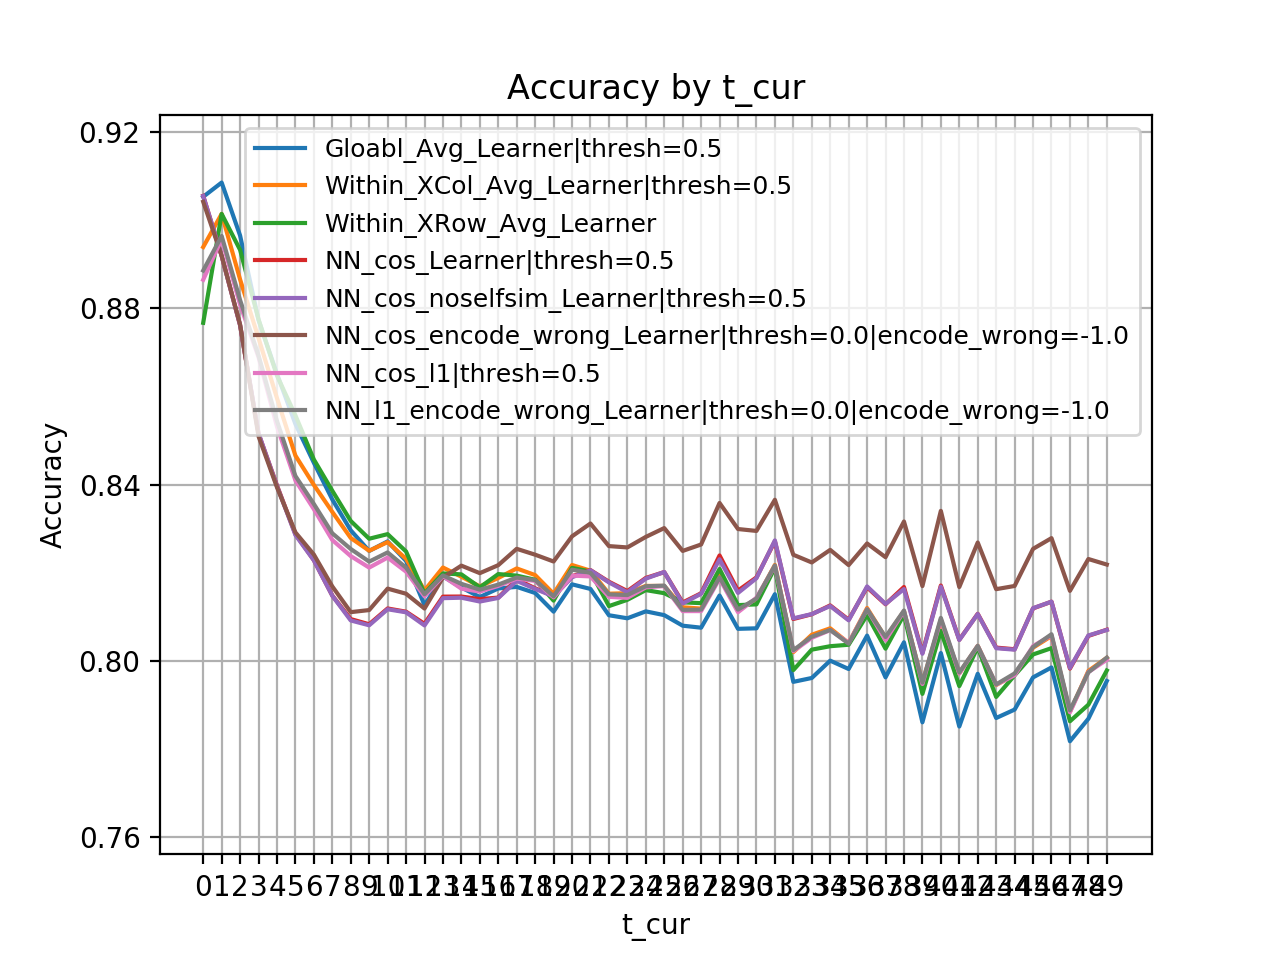

graphing complete


In [4]:
#plot the accuracy of previously run results
plot_test_2D_sparse_results_params = {
    'results':results,
    'x_range_col':'t_cur',
    'label_col':'Learner Name',
    'value_cols':['Accuracy'],
    'starting_figure':0
}
gu.plot_test_2D_sparse_results(**plot_test_2D_sparse_results_params)

#### 4.1.2) Positive and Negative Predictive Value

In [5]:
#plot the ppv and npv of previously run results
plot_test_2D_sparse_results_params = {
    'results':results,
    'x_range_col':'t_cur',
    'label_col':'Learner Name',
    'value_cols':['Positive Predictive Value', 'Negative Predictive Value'],
    'starting_figure':1
}
gu.plot_test_2D_sparse_results(**plot_test_2D_sparse_results_params)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

graphing complete


#### 4.1.3) True Positive and Negative Rates

<IPython.core.display.Javascript object>


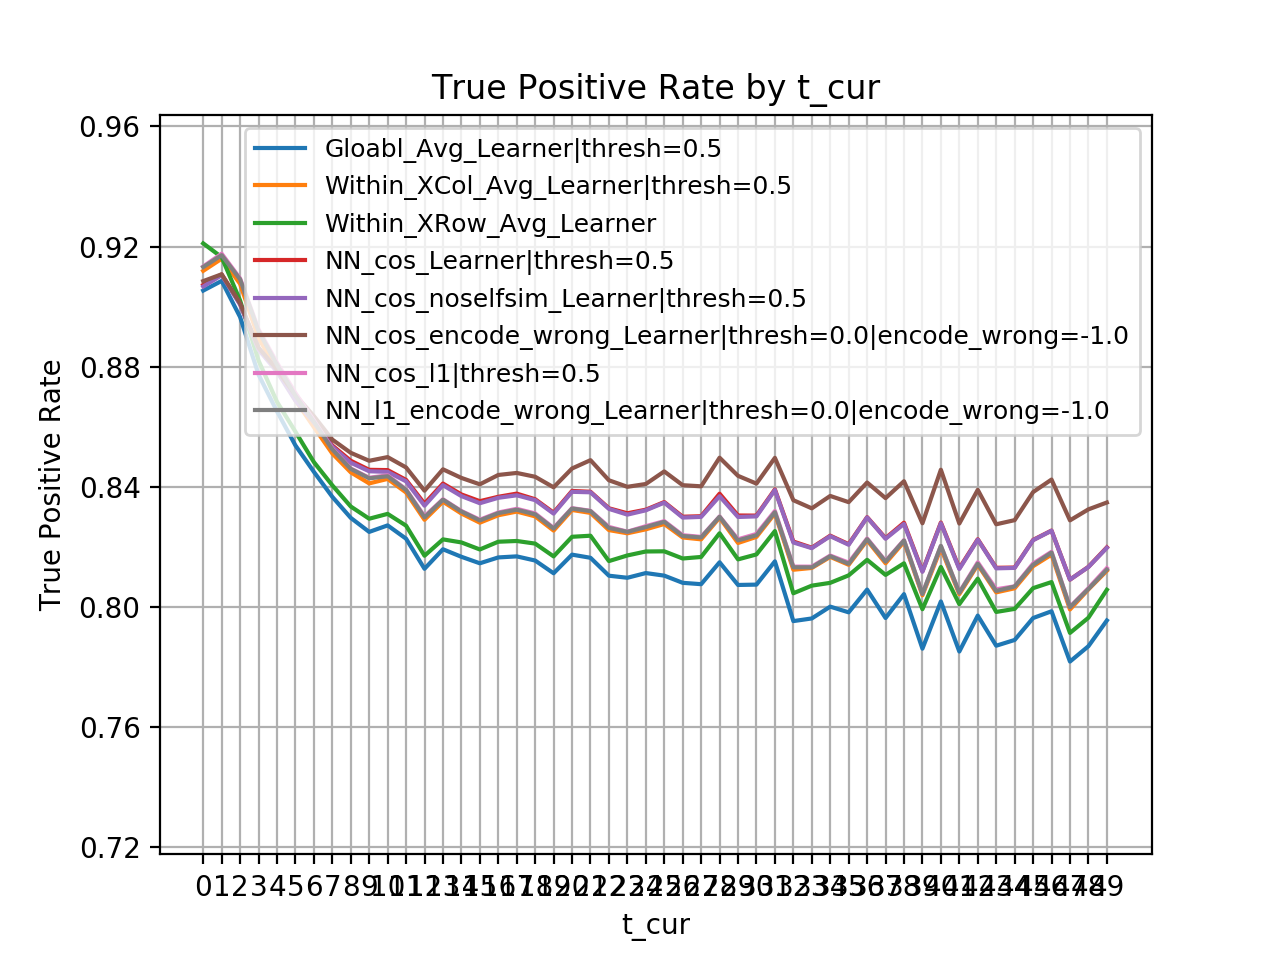

<IPython.core.display.Javascript object>

graphing complete


In [6]:
#plot the tpr and tnr of previously run results
plot_test_2D_sparse_results_params = {
    'results':results,
    'x_range_col':'t_cur',
    'label_col':'Learner Name',
    'value_cols':['True Positive Rate', 'True Negative Rate'],
    'starting_figure':3
}
gu.plot_test_2D_sparse_results(**plot_test_2D_sparse_results_params)

### 4.2) Custom Similarity Testing and Tuning 
#### 4.2.1) Accuracy

<IPython.core.display.Javascript object>


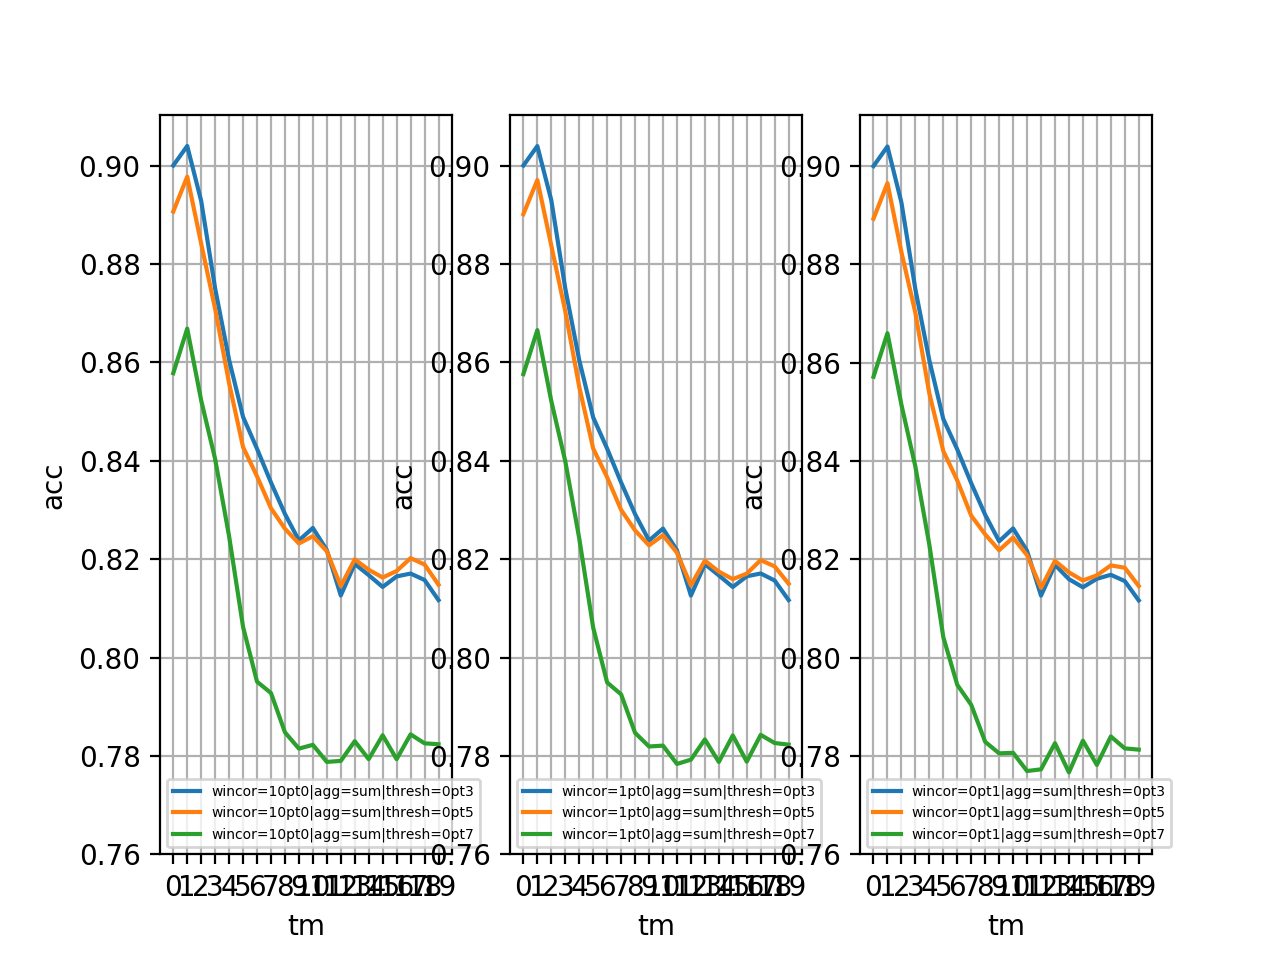

Loading pickle from results_parallel/custdist_20tm_wincor10pt0_aggsum_th0pt3.pickle
Loading pickle from results_parallel/custdist_20tm_wincor10pt0_aggsum_th0pt5.pickle
Loading pickle from results_parallel/custdist_20tm_wincor10pt0_aggsum_th0pt7.pickle
Loading pickle from results_parallel/custdist_20tm_wincor1pt0_aggsum_th0pt3.pickle
Loading pickle from results_parallel/custdist_20tm_wincor1pt0_aggsum_th0pt5.pickle
Loading pickle from results_parallel/custdist_20tm_wincor1pt0_aggsum_th0pt7.pickle
Loading pickle from results_parallel/custdist_20tm_wincor0pt1_aggsum_th0pt3.pickle
Loading pickle from results_parallel/custdist_20tm_wincor0pt1_aggsum_th0pt5.pickle
Loading pickle from results_parallel/custdist_20tm_wincor0pt1_aggsum_th0pt7.pickle


<IPython.core.display.Javascript object>


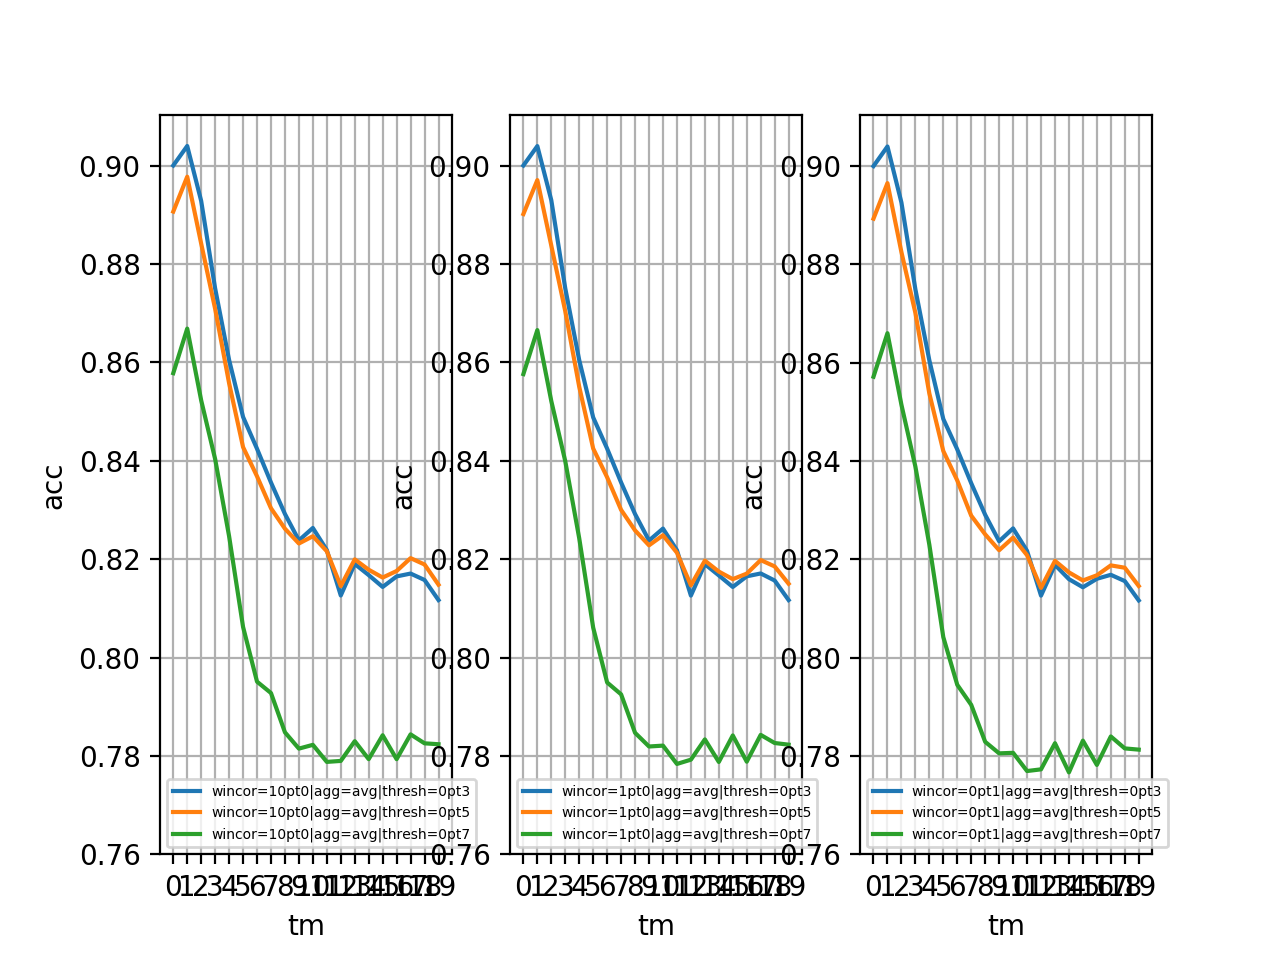

Loading pickle from results_parallel/custdist_20tm_wincor10pt0_aggavg_th0pt3.pickle
Loading pickle from results_parallel/custdist_20tm_wincor10pt0_aggavg_th0pt5.pickle
Loading pickle from results_parallel/custdist_20tm_wincor10pt0_aggavg_th0pt7.pickle
Loading pickle from results_parallel/custdist_20tm_wincor1pt0_aggavg_th0pt3.pickle
Loading pickle from results_parallel/custdist_20tm_wincor1pt0_aggavg_th0pt5.pickle
Loading pickle from results_parallel/custdist_20tm_wincor1pt0_aggavg_th0pt7.pickle
Loading pickle from results_parallel/custdist_20tm_wincor0pt1_aggavg_th0pt3.pickle
Loading pickle from results_parallel/custdist_20tm_wincor0pt1_aggavg_th0pt5.pickle
Loading pickle from results_parallel/custdist_20tm_wincor0pt1_aggavg_th0pt7.pickle


<IPython.core.display.Javascript object>


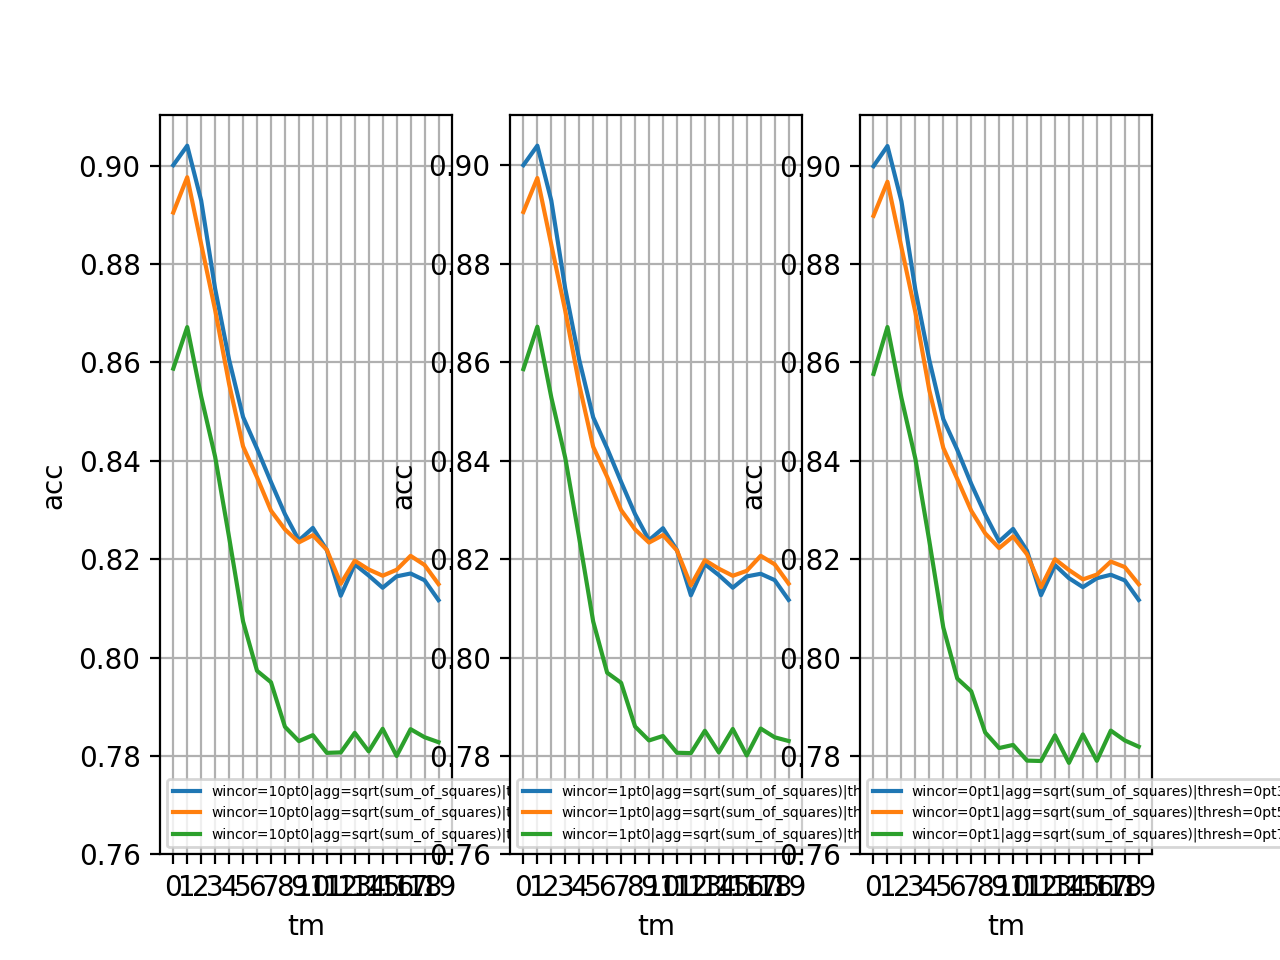

Loading pickle from results_parallel/custdist_20tm_wincor10pt0_aggsqrt(sum_of_squares)_th0pt3.pickle
Loading pickle from results_parallel/custdist_20tm_wincor10pt0_aggsqrt(sum_of_squares)_th0pt5.pickle
Loading pickle from results_parallel/custdist_20tm_wincor10pt0_aggsqrt(sum_of_squares)_th0pt7.pickle
Loading pickle from results_parallel/custdist_20tm_wincor1pt0_aggsqrt(sum_of_squares)_th0pt3.pickle
Loading pickle from results_parallel/custdist_20tm_wincor1pt0_aggsqrt(sum_of_squares)_th0pt5.pickle
Loading pickle from results_parallel/custdist_20tm_wincor1pt0_aggsqrt(sum_of_squares)_th0pt7.pickle
Loading pickle from results_parallel/custdist_20tm_wincor0pt1_aggsqrt(sum_of_squares)_th0pt3.pickle
Loading pickle from results_parallel/custdist_20tm_wincor0pt1_aggsqrt(sum_of_squares)_th0pt5.pickle
Loading pickle from results_parallel/custdist_20tm_wincor0pt1_aggsqrt(sum_of_squares)_th0pt7.pickle


In [11]:
import matplotlib.pyplot as plt

'''plot in a 3x3 grid the test results of cust_dist'''
aggs = ['sum', 'avg', 'sqrt(sum_of_squares)']
wincors = ['10pt0', '1pt0', '0pt1']
x_range = np.arange(20)
y_ticks = 0.76 + np.arange(8)*0.02


for i, agg in enumerate(aggs):
    f, axarr = plt.subplots(nrows=1, ncols=3)
    for j, wincor in enumerate(wincors):
        #load the 3 results of diff wincors
        th0pt3 = lu.load_pickle('custdist_20tm_wincor{}_agg{}_th0pt3'.format(wincor, agg), 'results_parallel')
        th0pt5 = lu.load_pickle('custdist_20tm_wincor{}_agg{}_th0pt5'.format(wincor, agg), 'results_parallel')
        th0pt7 = lu.load_pickle('custdist_20tm_wincor{}_agg{}_th0pt7'.format(wincor, agg), 'results_parallel')

        #plot in subplot i,j
        axarr[j].plot(x_range, th0pt3.loc[:, 'Accuracy'], label='wincor={}|agg={}|thresh=0pt3'.format(wincor, agg))
        axarr[j].plot(x_range, th0pt5.loc[:, 'Accuracy'], label='wincor={}|agg={}|thresh=0pt5'.format(wincor, agg))
        axarr[j].plot(x_range, th0pt7.loc[:, 'Accuracy'], label='wincor={}|agg={}|thresh=0pt7'.format(wincor, agg))

        axarr[j].legend(loc='best', prop={'size':5})
        axarr[j].set_xlabel('tm')
        axarr[j].set_ylabel('acc')
        axarr[j].set_xticks(x_range)
        axarr[j].set_yticks(y_ticks)
        axarr[j].grid()
        
plt.show()